In [1]:
import os

os.chdir("../..")

In [2]:

from datetime import datetime, timezone
from typing import Dict, List, Literal, cast
import os 
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_openai import ChatOpenAI as LangchainChatOpenAI
# from langchain_core.messages import HumanMessage, SystemMessage, MessagesPlaceholder
from langchain_core.messages import AIMessage
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from pydantic import BaseModel, Field
from src.react_agent.configuration import Configuration
from src.react_agent.state import InputState, OverallState, OutputState
from src.react_agent.tools import TOOLS
from src.react_agent.utils import load_chat_model
from typing import Any, List, Optional, Union
from typing_extensions import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph import add_messages
from dataclasses import dataclass, field
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI as LangchainChatDeepSeek
from langchain_core.prompts import MessagesPlaceholder
from langchain.schema import HumanMessage, SystemMessage, AIMessage  # Import AIMessage for assistant responses
from langgraph.checkpoint.memory import MemorySaver

import logging

# Suppress debug messages from ipywidgets
logging.getLogger('ipywidgets').setLevel(logging.WARNING)
# Suppress debug messages from the comm module
logging.getLogger('comm').setLevel(logging.WARNING)
# Define the state object
# state = OverallState()

from src.react_agent.agent import ( travel_itinerary_planner, flight_finder_tool_node,
                                accommodation_finder_node, activities_node, ticketmaster_node, recommendations_node, airbnb_node,
                                accomodation_router, accomodation_router_2, recommendations_node_2, recommendation_router)

from src.react_agent.tools import (TOOLS, amadeus_tool, amadeus_hotel_tool, geoapify_tool, weather_tool,  AmadeusFlightSearchInput,
                                   FlightSearchInput,
                                   googlemaps_tool, flight_tool, google_scholar_tool, booking_tool, tavily_search_tool,
                                   flight_tools_condition, accomodation_tools_condition, activity_planner_tools_condition,
                                   multiply_tool, GoogleMapsPlacesInput, google_places_tool, google_find_place_tool, google_place_details_tool,
                                   google_events_tool, GoogleEventsSearchInput, TicketmasterEventSearchInput, ticketmaster_tool)

from src.react_agent.pretty_print import pretty_print_output

from langchain.agents import create_react_agent, AgentExecutor
from src.react_agent.prompts import SYSTEM_PROMPT, FLIGHT_FINDER_PROMPT, ACTIVITY_PLANNER_PROMPT, RECOMMENDATION_PROMPT
from langchain.tools import BaseTool, Tool
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
from langgraph.prebuilt import tools_condition
from dotenv import load_dotenv

from datetime import date
import logging

# Suppress debug messages from ipywidgets
logging.getLogger('ipywidgets').setLevel(logging.WARNING)
logging.getLogger('comm').setLevel(logging.WARNING)
logging.getLogger('tornado').setLevel(logging.WARNING)
logging.getLogger('traitlets').setLevel(logging.WARNING)

# Disable all logging globally
logging.disable(logging.CRITICAL)  # Disable all logging below CRITICAL level

# Redirect all logging output to os.devnull
logging.basicConfig(level=logging.CRITICAL, handlers=[logging.NullHandler()])

# Suppress warnings as well (optional)
import warnings
warnings.filterwarnings("ignore")

# Load environment variables from the .env file
load_dotenv()

INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60
INFO:googlemaps.client:API queries_quota: 60


✅ API keys validated.


DEBUG:pydot:pydot initializing
DEBUG:pydot:pydot 3.0.4
DEBUG:pydot.dot_parser:pydot dot_parser module initializing
DEBUG:pydot.core:pydot core module initializing
DEBUG:httpx:load_ssl_context verify=True cert=None trust_env=True http2=False
DEBUG:httpx:load_verify_locations cafile='C:\\Users\\pault\\anaconda3\\envs\\app_project\\Library\\ssl\\cacert.pem'
DEBUG:httpx:load_ssl_context verify=True cert=None trust_env=True http2=False
DEBUG:httpx:load_verify_locations cafile='C:\\Users\\pault\\anaconda3\\envs\\app_project\\Library\\ssl\\cacert.pem'


True

In [3]:
llm = LangchainChatDeepSeek(
    api_key=os.getenv("DEEPSEEK_API_KEY"),
    model= "deepseek-chat",
    base_url="https://api.deepseek.com",
)

user_input = """
So I intend to visit a few states in the USA. I don't know which one I would start with but let's say I go to New York City because my friend 
lives in New York and I go to see him. I live in Oklahoma right now and so let's say I decide to go towards the middle of February 
to New York City to see him and I would probably like to go after Valentine's because he might have plans and let's say I go after Valentine's 
to see him in New York City. Just to give you some perspective, the year is 2025 and we are currently in January. January 27th is today but I 
intend to go next month. I don't really know some exciting things that they do in New York City so I don't really know what to expect. 
But I'm flexible to a lot of things. I'm flexible to partying, to just understanding the culture and what they actually do there. 
I wouldn't be living with him so I might have to rent a hostel or an Airbnb somewhere that is affordable in New York City. 
I think he lives close to the University of New York City so wherever I'm going to rent, it's going to likely be close to the 
University in New York City and I don't really know how cold it gets there so I pretty much need some information about what to do, 
where to stay, how to park because it gets really cold in New York City as I head. So I would like some advice, some itinerary, 
some guide on this entire travel. To come back, I don't really know when I want to come back but I know the maximum I want to spend 
there is like 2 or 3 days. Let's just say it's 3 days or 4 days. That's the maximum I want to spend there. So since I intend to go after 
Valentine's, I would recommend that you just pick a day after Valentine's, maybe a day on the weekend I guess. That would be preferable, 
a day on the weekend after Valentine's and then let's see how we can plan for that time.
"""    

user_input = """
I want to spend Valentine's Day, June 25, right, in Africa's largest city. You know, I probably would want to leave Dallas two or three days 
early, so I can, you know, get there in time, settle down, and then on Valentine's Day I would explore the city. You know, I don't really 
know what to expect, especially on Valentine's Day in a city, but I'm really open to a lot of things. I want to live somewhere on the island, 
somewhere close to Lake Kikuyu or Victoria Island, just that vicinity. You know, live in a very comfortable accommodation, whether 
that's an Airbnb or a hotel, right. I want to go to a nightclub or nightclubs. I want to go to the beach and explore some of the 
largest beaches there. I also want to, you know, get a car and drive around the city and see what it's like, right. I pretty much want to 
experience life in Africa's largest city, and I do intend staying for, let's say, seven days. Then I will come back after seven days, right. 
So that's my plan.
"""


> Test

In [4]:
def flight_tools_condition(
    state: Union[list[AnyMessage], dict[str, Any], BaseModel],
    messages_key: str = "messages",
) -> Literal["flight_tools", "__end__"]:
    """Use in the conditional_edge to route to the ToolNode if the last message

    has tool calls. Otherwise, route to the end.

    Args:
        state (Union[list[AnyMessage], dict[str, Any], BaseModel]): The state to check for
            tool calls. Must have a list of messages (MessageGraph) or have the
            "messages" key (StateGraph).

    Returns:
        The next node to route to.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif isinstance(state, dict) and (messages := state.get(messages_key, [])):
        ai_message = messages[-1]
    elif messages := getattr(state, messages_key, []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "flight_tools"
    return "__end__"    # you can change this to any other node name instead of "__end__"


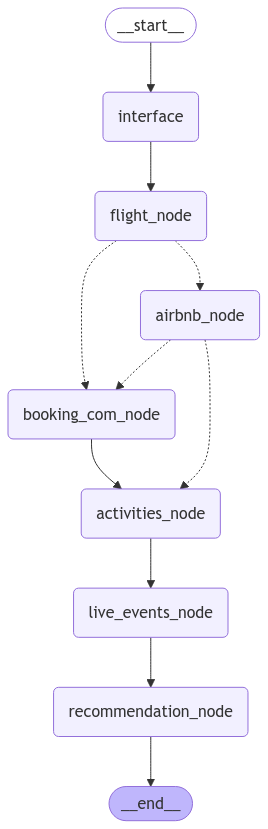

In [5]:

# Define a new graph
builder = StateGraph(OverallState, config_schema=Configuration)
builder.add_node("interface", travel_itinerary_planner)
builder.add_node("flight_node", flight_finder_tool_node)
builder.add_node("booking_com_node", accommodation_finder_node)
builder.add_node("airbnb_node", airbnb_node)
builder.add_node("activities_node", activities_node)
builder.add_node("live_events_node", ticketmaster_node)
builder.add_node("recommendation_node", recommendations_node)
builder.add_node("recommendation_node_2", recommendations_node_2)


# ----------------------------------------- Edges ---------------------------------------------------
builder.add_edge(START, "interface")
builder.add_edge("interface", "flight_node")

builder.add_conditional_edges(
    "flight_node",
    accomodation_router,
)
builder.add_conditional_edges(
    "airbnb_node",
    accomodation_router_2,
)

builder.add_conditional_edges(
    "recommendation_node",
    recommendation_router,
)

builder.add_edge("booking_com_node", "activities_node")
builder.add_edge("activities_node", "live_events_node")
builder.add_edge("live_events_node", "recommendation_node")
builder.add_edge("recommendation_node_2", END)

graph = builder.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)


In [6]:
# **Input Collection**
user_input = """
I want to travel from Oklahoma to Lagos on 2025-2-15 and return on 2025-2-22, if its cheaper to go by Dallas then that option can be used. 
There is 1 adult. My budget is $5000. I need 1 room in Victoria Island, Lagos for 5 days. I prefer an AirBnB with free breakfast and a swimming pool. 
I also want to visit the museums, the market, enjoy local cuisine, and go to the club at night. I might also want an exotic massage.
Also, give me some recommendations in Lagos to stay safe and have fun, and what to expect generally in Africa's largest city.    
"""

# **Input State**
input_state = {"messages": [HumanMessage(content=user_input)]}

# **Graph Invocation**
output = graph.invoke(input_state, {"recursion_limit": 3000})
# output.get("messages")[-1].content


pretty_print_output(output)


======================== TRIP OVERVIEW ======================

TRIP OVERVIEW
+-------------+------------+
| Field       | Value      |
+-------------+------------+
| Location    | Oklahoma   |
| Destination | Lagos      |
| Start Date  | 2025-02-15 |
| End Date    | 2025-02-22 |
| Budget      | 5000.0     |
| Adults      | 1          |
| Children    | 0          |
+-------------+------------+


========================== FLIGHTS ==========================

Flight Option #1

--- ECONOMY ---
+---+---------------------+-------+---------------------------------------------------------------------+--------------------------------------+----------+----------+---------+---------+
| # | Airlines            | Price | Route                                                               | Times                                | Duration | Layovers | Class   | Booking |
+---+---------------------+-------+---------------------------------------------------------------------+-------------------------

In [19]:
llm = LangchainChatDeepSeek(
    api_key=os.getenv("OPENAI_API_KEY"),
    model= "gpt-4o"
)

In [58]:
RECOMMENDATION_PROMPT_2 = """
You are a specialized travel recommendation assistant. Your role is to provide users with practical and often-overlooked travel recommendations for their destination. Focus on offering unique insights that help travelers navigate and adapt effectively to the local environment.

### User Query:
{query}

### Instructions:
1. Use the provided tools (e.g., Weather Tool, Travel Research Tool) to gather accurate information about the user's destination.
2. Your output should consist of **at least 10 recommendations** in the form of a list of dictionaries. 
  - recommendations: [{}, {}, {}, ...]
3. Each dictionary must contain:
   - **Key**: A concise label describing the recommendation type (e.g., "Crime Rate", "Emergency Services", "Cultural Norms").
   - **Value**: A brief, actionable, and location-specific piece of advice related to the key.
4. Tailor the recommendations to include any user preferences (e.g., budget constraints, eco-friendly practices, health concerns).
5. Focus on **non-standard travel tips** such as:
   - Safety tips (e.g., crime statistics, common scams, or safe neighborhoods).
   - Local laws and regulations (e.g., alcohol restrictions, driving rules).
   - Cultural norms (e.g., appropriate dress, tipping etiquette, gestures to avoid).
   - Health and safety precautions (e.g., vaccinations, emergency contacts, high-risk areas).
   - Environmental considerations (e.g., weather patterns, eco-friendly practices).
   - Financial guidance (e.g., currency exchange tips, hidden fees, accepted payment methods).
6. Avoid generic tourist suggestions (e.g., flights, hotels, restaurants, tourist attractions).
7. Ensure your output is accurate, concise, and practical.

### Example Output:
For example, if the user query is "I want to travel from New York to Los Angeles on July 1st, 2022, with a budget of $5000 for 2 adults and 1 child, and return on July 20th, 2022" 
    - recommendations: 
        [[
            {{"Crime Rate": "The area has a moderate crime rate; avoid traveling alone at night in secluded areas."}}
            {{"Local Emergency Numbers": "Police: 123, Ambulance: 456, Fire: 789. Save these numbers for emergencies."}},
            {{"Weather Tips": "Pack lightweight, breathable clothing for hot days and a jacket for cool nights."}},
            {{"Cultural Norms": "Tipping is not customary, but small gestures of appreciation are welcomed."}},
            {{"Local Laws": "Smoking in public spaces is prohibited and can result in fines."}},
            {{"Currency Exchange": "ATMs widely accept international cards; ensure to carry some local cash for small vendors."}},
            {{"Health Precautions": "Consider anti-mosquito measures and stay hydrated in the heat."}},
            {{"Transportation Advice": "Public transit is efficient, but purchase tickets in advance during peak hours."}},
            {{"Eco-Friendly Practices": "Bring a reusable water bottle; public refill stations are common."}},
            {{"Packing Suggestions": "Carry sunscreen and a wide-brimmed hat due to high UV levels."}}
        ]]
"""


In [59]:
llm_with_structure_op = llm

# Define the prompt template
prompt = PromptTemplate(
    template=RECOMMENDATION_PROMPT_2,
    input_variables=["query"]
)

# Create the chain
chain = prompt | llm_with_structure_op

try:
    structured_output = chain.invoke({"query": user_input})
    print(f"Raw Model Response:\n{structured_output}")
except Exception as e:
    print(f"Error during invocation: {e}")
    structured_output = None


Error during invocation: "Input to PromptTemplate is missing variables {''}.  Expected: ['', 'query'] Received: ['query']\nNote: if you intended {} to be part of the string and not a variable, please escape it with double curly braces like: '{{}}'.\nFor troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_PROMPT_INPUT "


In [52]:
from typing import List, Dict, Optional
from pydantic import BaseModel, Field

class Recommendations(BaseModel):
    recommendations: Optional[List[Dict[str, str]]] = Field(description="Recommendations given to the traveler.")

def recommendations_node_2(state: OverallState):
    # Define the LLM with structured output
    # llm_with_structure_op = llm.with_structured_output(Recommendations)
    llm_with_structure_op = llm

    # Define the prompt template
    prompt = PromptTemplate(
        template=RECOMMENDATION_PROMPT_2,
        input_variables=["query"]
    )

    # Create the chain
    chain = prompt | llm_with_structure_op

    # Concatenate all messages from the state
    messages = state.messages
    all_messages = "\n".join([message.content for message in messages])

    # Extract user preferences and convert the dictionary into a text representation
    preferences = state.user_preferences
    preferences_text = "\n".join([f"{key}: {value}" for key, value in preferences.items()])

    # Construct the query by combining all messages and preferences text
    query = f"{all_messages}\n\nUser Preferences:\n{preferences_text}"

    # Invoke the chain with the user's query
    try:
        structured_output = chain.invoke({"query": query})
        print(f"Raw Model Response:\n{structured_output}")
    except Exception as e:
        print(f"Error during invocation: {e}")
        structured_output = None


    # Return the recommendations
    return structured_output



state = OverallState(
    messages=[HumanMessage(content=user_input)],
    user_preferences={"budget": 5000, "travel_class": "Economy"}
)

output = recommendations_node_2(state)

# Print the final output
print("Final Recommendations:")
print(output)


Error during invocation: "Input to PromptTemplate is missing variables {''}.  Expected: ['', 'query'] Received: ['query']\nNote: if you intended {} to be part of the string and not a variable, please escape it with double curly braces like: '{{}}'.\nFor troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_PROMPT_INPUT "
Final Recommendations:
None


In [86]:
RECOMMENDATION_PROMPT_2 = """
You are a travel recommendation assistant. Your task is to generate at least 10 recommendations for the user's destination. Focus on providing practical and unique travel advice. Avoid recommending flights, hotels, or tourist attractions.

### User Query:
{query}

### Instructions:
1. Each recommendation must be in the form of a dictionary.
2. Include details like safety tips, cultural norms, emergency contacts, local laws, weather advice, health precautions, and eco-friendly practices.
3. Tailor recommendations to user preferences, such as budget and travel class.
4. Output the recommendations as a list of dictionaries.

### Example Output:
[
    {"Crime Rate": "Paris is generally safe, but beware of pickpockets in crowded areas."},
    {"Emergency Numbers": "Police: 112, Ambulance: 15, Fire: 18."},
    {"Cultural Norms": "Tipping is not mandatory but appreciated in restaurants."},
    {"Local Laws": "Smoking is banned in enclosed public spaces."},
    {"Currency Tips": "The currency is Euro (€). Credit cards are widely accepted."},
    {"Health Advice": "Carry a reusable water bottle; tap water is safe to drink."},
    {"Eco-Friendly Travel": "Use public transportation or rent a bike to reduce your carbon footprint."},
    {"Weather Tips": "Paris has mild weather in spring; pack a light jacket."},
    {"Packing Advice": "Bring comfortable shoes for walking and a travel adapter for plugs."},
    {"Connectivity": "Free Wi-Fi is available in many cafes and public areas."}
]
"""


> Open AI

In [16]:
from pydantic import BaseModel, Field
from typing import List, Dict
import json

# class Recommendations(BaseModel):
#     recommendations: List[Dict[str, str]] = Field(
#         ...,
#         description="A list of travel recommendations where each item has {key, value}."
#     )


RECOMMENDATION_PROMPT_2 = """
You are a specialized travel recommendation assistant. 
Generate at least 10 unique recommendations for the user. 
Output your response as a list of dictionaries, each containing the fields: 
  - "key": A short label, e.g. "Crime Rate"
  - "value": A concise recommendation

For example:
[
    {"key": "Crime Rate", "value": "The city is generally safe but beware of pickpockets in tourist areas."},
    {"key": "Weather Advice", "value": "Spring is mild; pack light jackets and an umbrella."}
]

### User Query:
{query}
"""



def recommendations_node_2(state: OverallState) -> OverallState:
    import openai
    
    # If you haven't set up your API key globally, do so here:
    # openai.api_key = "YOUR_OPENAI_API_KEY"
    
    client = openai  # or adapt to your environment if needed

    # Combine all user messages into a single query
    all_messages = "\n".join([message.content for message in state.messages])
    preferences_text = "\n".join([f"{key}: {value}" for key, value in state.user_preferences.items()])
    query = f"{all_messages}\n\nUser Preferences:\n{preferences_text}"

    # Define the structured response format with a JSON Schema
    completion = client.chat.completions.create(
        model="gpt-4o",  # Replace with a valid model you have access to.
        messages=[
            {"role": "system", "content": RECOMMENDATION_PROMPT_2},
            {"role": "user", "content": query},
        ],
        # The 'response_format' parameter needs 'json_schema' -> 'name' + 'schema'
        response_format={
            "type": "json_schema",
            "json_schema": {
                "name": "recommendation_schema",
                "schema": {
                    "type": "object",
                    "properties": {
                        "recommendations": {
                            "type": "array",
                            "items": {
                                "type": "object",
                                "properties": {
                                    "key": {
                                        "type": "string",
                                        "description": "Short label for the recommendation"
                                    },
                                    "value": {
                                        "type": "string",
                                        "description": "Concise recommendation content"
                                    }
                                },
                                "required": ["key", "value"],
                                "additionalProperties": False
                            },
                            "description": "A list of travel recommendations."
                        }
                    },
                    "required": ["recommendations"],
                    "additionalProperties": False
                }
            },
        },
    )

    # Parse and return the generated structured output
    try:
        structured_output = completion.choices[0].message.content
        parsed_output = json.loads(structured_output)
        recommendation_list = parsed_output["recommendations"]  # This is the list of dictionaries
        transformed_list = [{item["key"]: item["value"]} for item in recommendation_list]
        
        state.recommendations = transformed_list
        
        return state 
    
    except Exception as e:
        print(f"Error occurred: {e}")
        return {"error": "Failed to generate recommendations."}


# Example usage:
user_input = "I want to travel to Paris in the spring. My budget is $3000."
state = OverallState(
    messages=[HumanMessage(content=user_input)],
    user_preferences={"budget": 3000, "travel_class": "Economy"}
)
recommendations = recommendations_node_2(state)
print(recommendations)


[{'key': 'Weather Advice', 'value': 'Spring weather in Paris can be unpredictable; prepare for both sunny days and rainy spells with a waterproof jacket and umbrella.'}, {'key': 'Public Transportation', 'value': "Purchase a 'Navigo Easy' pass for unlimited travel on public transportation to save money and avoid buying single tickets."}, {'key': 'Free Activities', 'value': "Explore Paris on a budget by enjoying free activities such as visiting the Sacré-Cœur, wandering along the Seine, and exploring the city's various parks and gardens."}, {'key': 'Cultural Norms', 'value': "Parisians appreciate polite formalities; always greet with 'Bonjour' and thank storekeepers with 'Merci.'"}, {'key': 'Picnic Spots', 'value': 'Take advantage of budget-friendly meals by having a picnic at the Champ de Mars or along the Seine River.'}, {'key': 'Eco-Friendly Practices', 'value': 'Carry a reusable water bottle; Paris has many public drinking water fountains to refill free of charge.'}, {'key': 'Tipping

In [18]:
recommendations

transformed_list = [{item["key"]: item["value"]} for item in recommendations]
print(transformed_list)

[{'Weather Advice': 'Spring weather in Paris can be unpredictable; prepare for both sunny days and rainy spells with a waterproof jacket and umbrella.'}, {'Public Transportation': "Purchase a 'Navigo Easy' pass for unlimited travel on public transportation to save money and avoid buying single tickets."}, {'Free Activities': "Explore Paris on a budget by enjoying free activities such as visiting the Sacré-Cœur, wandering along the Seine, and exploring the city's various parks and gardens."}, {'Cultural Norms': "Parisians appreciate polite formalities; always greet with 'Bonjour' and thank storekeepers with 'Merci.'"}, {'Picnic Spots': 'Take advantage of budget-friendly meals by having a picnic at the Champ de Mars or along the Seine River.'}, {'Eco-Friendly Practices': 'Carry a reusable water bottle; Paris has many public drinking water fountains to refill free of charge.'}, {'Tipping Etiquette': 'Service charge is included in dining bills, but leaving small change as a tip for excepti

In [89]:

recommendation_list

[{'key': 'Safety Tips',
  'value': 'Paris is generally safe, but remain vigilant in crowded areas like metros and tourist sites to avoid pickpockets.'},
 {'key': 'Cultural Norms',
  'value': "Parisians appreciate politeness. Always greet with a 'Bonjour' when entering shops or engaging in conversations."},
 {'key': 'Emergency Contacts',
  'value': 'For any emergencies, dial 112 for immediate assistance in Paris.'},
 {'key': 'Public Transport',
  'value': "Purchase a Navigo card for affordable and efficient public transport. It's perfect for budget travel across the city."},
 {'key': 'Dining on a Budget',
  'value': 'Opt for a ‘plat du jour’ (dish of the day) at local bistros for an affordable and authentic French meal experience.'},
 {'key': 'Weather Advice',
  'value': 'Spring in Paris can be mild but unpredictable; pack layers including a waterproof jacket and comfortable walking shoes.'},
 {'key': 'Health Precautions',
  'value': 'Paris tap water is safe to drink, reducing the need 